In [1]:
import math
import tensorflow as tf
import numpy as np
import pylab as plt

/Users/lzcai/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# scale data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

In [3]:
def process_inputs_from_file(fileName): # Read in data
    inputs = np.loadtxt(fileName, delimiter=' ')
    X, _Y = inputs[:, :NUM_FEATURES], inputs[:, -1].astype(int)
    X = scale(X, np.min(X, axis=0), np.max(X, axis=0))
    _Y[_Y == 7] = 6 # Actually dont have, just in case have error data

    Y = np.zeros((_Y.shape[0], NUM_CLASSES))
    Y[np.arange(_Y.shape[0]), _Y - 1] = 1 #one hot matrix
    return X, Y

In [4]:
def init_weights (feature_no, neuron_no, logistic = True):
    # From eg.5.2
    n_in = feature_no
    n_out = neuron_no
    W_values = np.asarray(np.random.uniform(low=-np.sqrt(6. / (n_in + n_out)),
                                            high=np.sqrt(6. / (n_in + n_out)),
                                            size=(n_in, n_out)))
    if logistic == True:
        W_values *= 4
    return(tf.Variable(W_values, dtype=tf.float32))

In [5]:
def init_bias(neuron_no = 1):
    # From eg.5.2
    return(tf.Variable(np.zeros(neuron_no), dtype=tf.float32))

In [6]:
# Initialize Values
NUM_FEATURES = 36
NUM_CLASSES = 6
NUM_HIDDEN = 10

LEARNING_RATE = 0.01
EPOCHS = 5000
BATCH_SIZE = 32
NUM_NEURONS = 10
SEED = 10
BETA = pow(10, -6)
np.random.seed(SEED)

TRAIN_FILE_NAME = 'sat_train.txt'
TEST_FILE_NAME = 'sat_test.txt'

In [7]:
trainX, trainY = process_inputs_from_file(TRAIN_FILE_NAME)
testX, testY = process_inputs_from_file(TEST_FILE_NAME)

In [8]:
trainY.shape

(4435, 6)

In [9]:
testY.shape

(2000, 6)

In [10]:
weight_1 = init_weights(NUM_FEATURES, NUM_HIDDEN)
bias_1 = init_bias(NUM_HIDDEN)
weight_2 = init_weights(NUM_HIDDEN, NUM_CLASSES)
bias_2 = init_bias(NUM_CLASSES)

In [11]:
trainX[0].shape

(36,)

In [12]:
x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
d = tf.placeholder(tf.float32, [None, NUM_CLASSES])

syn_input_1 = tf.matmul(x, weight_1) + bias_1
output_1 = tf.nn.sigmoid(syn_input_1)
syn_input_2 = tf.matmul(output_1, weight_2) + bias_2
# output_2 = tf.nn.softmax(syn_input_2)
# output_2 = tf.nn.sigmoid(syn_input_2)
output_2 = syn_input_2

In [13]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=trainY, logits=output_2)
regularization_factor = tf.nn.l2_loss(weight_1) + tf.nn.l2_loss(weight_2) 
loss = tf.reduce_mean(cross_entropy + BETA * regularization_factor)

In [14]:
optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE)
train_op = optimizer.minimize(loss)
correct_prediction = tf.cast(tf.equal(tf.argmax(output_2, 1), tf.argmax(trainY, 1)), tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

In [15]:
# sess = tf.Session()
# print(sess.run(weight_1))

In [16]:
weight_1.value()

<tf.Tensor 'Variable/read:0' shape=(36, 10) dtype=float32>

In [17]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
train_acc = []
print("********* BEFORE **********")
print(weight_1.eval())
print(bias_1.eval())
print(weight_2.eval())
print(bias_2.eval())
print("***************************")
for i in range(EPOCHS):
    train_op.run(feed_dict={x: trainX, d: trainY})
    train_acc.append(accuracy.eval(feed_dict={x: trainX, d: trainY}))

    if i % 100 == 0:
        print('iter %d: accuracy %g'%(i, train_acc[i]))
print("********* AFTER **********")
print(weight_1.eval())
print(bias_1.eval())
print(weight_2.eval())
print(bias_2.eval())
print("**************************")

********* BEFORE **********
[[ 0.783916   -1.3846724   0.38614455  0.7188592  -0.00431363 -0.7951342
  -0.872375    0.7527411  -0.956025   -1.1893935 ]
 [ 0.5355528   1.3099715  -1.4332227   0.03522662  0.90324336  0.3251171
   0.64070886 -0.60132426  1.2070583   0.6199653 ]
 [ 0.12292176 -1.0338639  -0.36595154  0.5031174  -0.16805911 -0.19065076
   0.34025946  0.03795981  0.43453664  0.29192784]
 [ 0.8818693   0.06254426  1.180693   -0.522274   -1.1832696  -0.57582945
  -1.1152997   0.94964594 -1.3091346   0.36487648]
 [ 0.1374888   0.9225033  -0.869819    1.0310335  -0.42861417  0.7357435
  -0.5895198   1.1092925  -0.50414234 -0.96785635]
 [-0.310511   -1.1745988   0.92775786 -1.0079126  -0.33482355  1.283585
   1.408877   -0.12624754  0.9422538  -0.71834487]
 [ 0.28133205  1.1638858   0.09984691  0.26061523 -1.331135   -0.4126391
  -1.2146072  -0.562077   -0.48909602  0.7911671 ]
 [-1.3291776  -0.20371546 -0.5347245   0.39435846 -0.4439431  -1.3201108
   1.0976739   0.76057065  1.0

In [18]:
# x = tf.placeholder(tf.float32, testX.shape)
# d = tf.placeholder(tf.float32, testY.shape)

# syn_input_1 = tf.matmul(x, weight_1) + bias_1
# output_1 = tf.nn.sigmoid(syn_input_1)
# syn_input_2 = tf.matmul(output_1, weight_2) + bias_2
# # output_2 = tf.nn.softmax(syn_input_2)
# # output_2 = tf.nn.sigmoid(syn_input_2)
# output_2 = syn_input_2

# cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(
#     labels=testY, logits=output_2)
# regularization_factor = tf.nn.l2_loss(weight_1) + tf.nn.l2_loss(weight_2) 
# loss = tf.reduce_mean(cross_entropy + BETA * regularization_factor)
# correct_prediction = tf.cast(tf.equal(tf.argmax(output_2, 1), 
#                                       tf.argmax(testY, 1)), tf.float32)
# accuracy = tf.reduce_mean(correct_prediction)

print("********* BEFORE **********")
print(weight_1.eval())
print(bias_1.eval())
print(weight_2.eval())
print(bias_2.eval())
print("***************************")
output_2_, accuracy_ = sess.run([output_2, accuracy], feed_dict={x: testX, d: testY})
print(output_2_, '\n',accuracy_)

********* BEFORE **********
[[ 1.34316325e+00 -1.37867224e+00  5.02205431e-01  7.98512876e-01
  -5.42528033e-01 -7.76729822e-01 -8.04631650e-01  6.24946058e-01
  -1.04125714e+00 -1.35174906e+00]
 [ 6.83482766e-01  1.48390126e+00 -1.50209355e+00  3.08609456e-02
   1.07896340e+00  4.27570671e-01  6.72380567e-01 -7.40326703e-01
   1.17115319e+00  5.39778352e-01]
 [-2.70642098e-02 -1.06741345e+00 -4.79112118e-01  6.72726333e-01
   7.61301897e-04 -5.35385132e-01  2.69433379e-01  1.84784085e-01
   7.52956331e-01  6.28287792e-01]
 [ 5.84430575e-01 -8.89399499e-02  1.23677111e+00 -3.13759685e-01
  -1.07933640e+00 -7.38812268e-01 -1.15843320e+00  1.10352385e+00
  -1.16920924e+00  6.87823534e-01]
 [ 7.16601074e-01  9.23115253e-01 -7.60355115e-01  1.10952866e+00
  -9.87104297e-01  8.26357663e-01 -4.91513640e-01  9.78765666e-01
  -5.38739562e-01 -1.18659317e+00]
 [-1.55983835e-01 -1.00441325e+00  8.43285739e-01 -1.01599193e+00
  -1.58634827e-01  1.45026588e+00  1.46627629e+00 -2.62876898e-01
   9.

InvalidArgumentError: Incompatible shapes: [2000] vs. [4435]
	 [[Node: Equal = Equal[T=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"](ArgMax, ArgMax_1)]]

Caused by op 'Equal', defined at:
  File "/Users/lzcai/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/lzcai/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/lzcai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/lzcai/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/lzcai/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/lzcai/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/Users/lzcai/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/Users/lzcai/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/Users/lzcai/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/lzcai/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/Users/lzcai/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/lzcai/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/lzcai/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/lzcai/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/lzcai/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/lzcai/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/lzcai/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/lzcai/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/lzcai/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/lzcai/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/lzcai/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/lzcai/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/lzcai/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/lzcai/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-38707024f34e>", line 3, in <module>
    correct_prediction = tf.cast(tf.equal(tf.argmax(output_2, 1), tf.argmax(trainY, 1)), tf.float32)
  File "/Users/lzcai/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2529, in equal
    "Equal", x=x, y=y, name=name)
  File "/Users/lzcai/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/lzcai/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/Users/lzcai/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Incompatible shapes: [2000] vs. [4435]
	 [[Node: Equal = Equal[T=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"](ArgMax, ArgMax_1)]]


In [20]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_acc = []
    print("********* BEFORE **********")
    print(weight_1.eval())
    print(bias_1.eval())
    print(weight_2.eval())
    print(bias_2.eval())
    print("***************************")
    for i in range(EPOCHS):
        train_op.run(feed_dict={x: trainX, d: trainY})
        train_acc.append(accuracy.eval(feed_dict={x: trainX, d: trainY}))

        if i % 100 == 0:
            print('iter %d: accuracy %g'%(i, train_acc[i]))
    print("********* AFTER **********")
    print(weight_1.eval())
    print(bias_1.eval())
    print(weight_2.eval())
    print(bias_2.eval())
    print("**************************")

********* BEFORE **********
[[ 0.783916   -1.3846724   0.38614455  0.7188592  -0.00431363 -0.7951342
  -0.872375    0.7527411  -0.956025   -1.1893935 ]
 [ 0.5355528   1.3099715  -1.4332227   0.03522662  0.90324336  0.3251171
   0.64070886 -0.60132426  1.2070583   0.6199653 ]
 [ 0.12292176 -1.0338639  -0.36595154  0.5031174  -0.16805911 -0.19065076
   0.34025946  0.03795981  0.43453664  0.29192784]
 [ 0.8818693   0.06254426  1.180693   -0.522274   -1.1832696  -0.57582945
  -1.1152997   0.94964594 -1.3091346   0.36487648]
 [ 0.1374888   0.9225033  -0.869819    1.0310335  -0.42861417  0.7357435
  -0.5895198   1.1092925  -0.50414234 -0.96785635]
 [-0.310511   -1.1745988   0.92775786 -1.0079126  -0.33482355  1.283585
   1.408877   -0.12624754  0.9422538  -0.71834487]
 [ 0.28133205  1.1638858   0.09984691  0.26061523 -1.331135   -0.4126391
  -1.2146072  -0.562077   -0.48909602  0.7911671 ]
 [-1.3291776  -0.20371546 -0.5347245   0.39435846 -0.4439431  -1.3201108
   1.0976739   0.76057065  1.0

In [14]:
writer = tf.summary.FileWriter('.')
writer.add_graph(tf.get_default_graph())

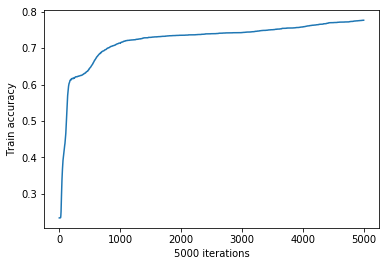

In [15]:
# plot learning curves
plt.figure(1)
plt.plot(range(EPOCHS), train_acc)
plt.xlabel(str(EPOCHS) + ' iterations')
plt.ylabel('Train accuracy')
plt.show()

In [21]:
# sess = tf.Session()
# weight_1_ = sess.run(weight_1)